In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
train_path = '/kaggle/input/melanoma-cancer-dataset/train'
test_path = '/kaggle/input/melanoma-cancer-dataset/test'

In [3]:
def extract_from_path(path)-> []:
    image_paths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [4]:
train_images = extract_from_path(train_path)
test_images = extract_from_path(test_path)

print(f"The length of train_images is {len(train_images)}")
print(f"The length of test_images is {len(test_images)}")

The length of train_images is 11879
The length of test_images is 2000


In [5]:
#randomly shuffle the list 
import random
random.seed(42)
random.shuffle(train_images)
random.shuffle(test_images)

#### Create a pandas dataframe

In [6]:
def createDataFrame(image_paths):
    labels = [path.split('/')[-2] for path in image_paths]
    df = pd.DataFrame({'path': image_paths, 'label': labels})
    df['label_id'] = df['label'].apply(lambda x: 1 if x == 'Malignant' else 0)
    return df

In [7]:
train_images_df = createDataFrame(train_images)
test_images_df = createDataFrame(test_images)
class_names = train_images_df['label_id'].nunique()

In [8]:
train_images_df.head(10)

,path,label,label_id
0,/kaggle/input/melanoma-cancer-dataset/train/Be...,Benign,0
1,/kaggle/input/melanoma-cancer-dataset/train/Be...,Benign,0
2,/kaggle/input/melanoma-cancer-dataset/train/Be...,Benign,0
3,/kaggle/input/melanoma-cancer-dataset/train/Be...,Benign,0
4,/kaggle/input/melanoma-cancer-dataset/train/Be...,Benign,0
5,/kaggle/input/melanoma-cancer-dataset/train/Be...,Benign,0
6,/kaggle/input/melanoma-cancer-dataset/train/Be...,Benign,0
7,/kaggle/input/melanoma-cancer-dataset/train/Ma...,Malignant,1
8,/kaggle/input/melanoma-cancer-dataset/train/Ma...,Malignant,1
9,/kaggle/input/melanoma-cancer-dataset/train/Ma...,Malignant,1


In [9]:
train_images_df.iloc[1]['path']

'/kaggle/input/melanoma-cancer-dataset/train/Benign/15.jpg'

In [10]:
def plotCount(df):
    name = df["path"][0].split("/")[3]
    malignant = df[df['label_id'] == 1]
    benign = df[df['label_id'] == 0]    
    print(f"Total images in {name} is {len(df)}")
    print(f"Total malignant images is {len(malignant)} {round(len(malignant)/len(df) * 100,2)}%")
    print(f"Total benign images is {len(df)-len(malignant)} {round(len(benign)/len(df) * 100,2)}%")
    sns.set_style("whitegrid")
    sns.countplot(x='label_id', data=df)

Total images in melanoma-cancer-dataset is 11879
Total malignant images is 5590 47.06%
Total benign images is 6289 52.94%


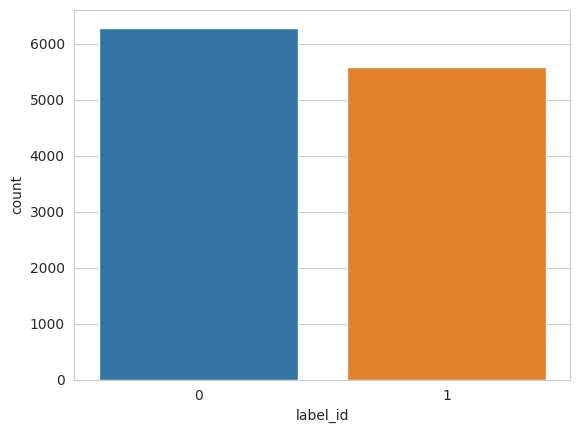

In [11]:
plotCount(train_images_df)

Total images in melanoma-cancer-dataset is 2000
Total malignant images is 1000 50.0%
Total benign images is 1000 50.0%


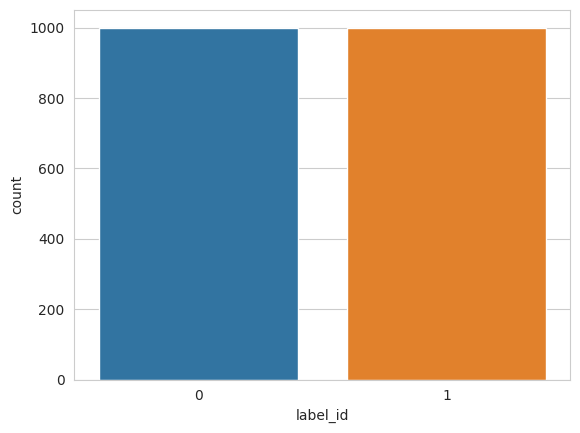

In [12]:
plotCount(test_images_df)

*As we can see in both the training and the testing dataset has almost the same no of datapoints for each class (malignant & benign)*

#### Visualize the data

In [13]:
from PIL import Image
def plot_random(df):
    img_path = df['path'].tolist()
    random_image_path = random.choice(img_path)
    image_class = random_image_path.split("/")[-2]
    img = Image.open(random_image_path)
    
    img_arr = np.array(img)
    plt.figure(figsize=(4,4))
    plt.imshow(img_arr)
    plt.title(f"Image class {image_class} \n Image shape {img_arr.shape}",fontsize = 9)
    plt.axis(False)

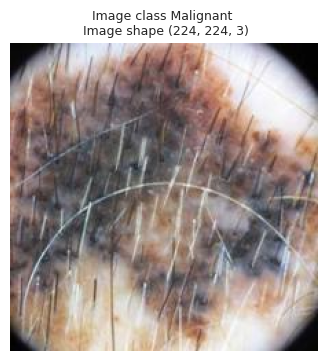

In [14]:
plot_random(train_images_df)

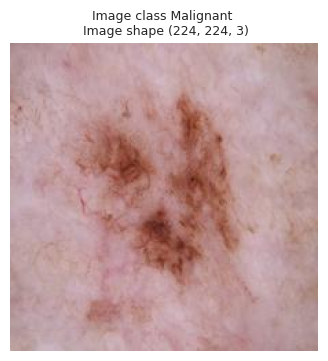

In [15]:
plot_random(train_images_df)

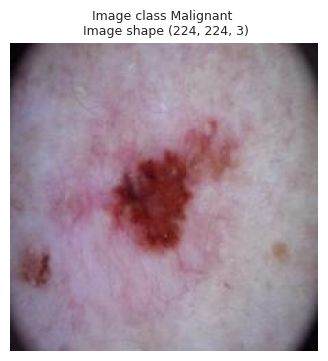

In [16]:
plot_random(train_images_df)

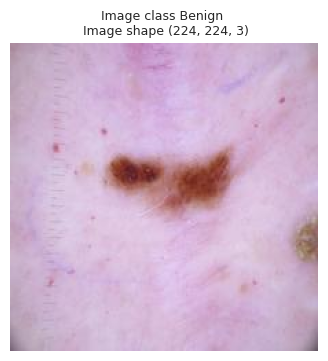

In [17]:
plot_random(train_images_df)

#### Fitting a baseline model (Efficientnet b0)

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [19]:
#cuda if availabele 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
# Load the pretrained model
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [21]:
# get the transformations used on the model
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [22]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os
def get_dataloaders(transforms,batchsize=32):
    train_data = datasets.ImageFolder(root=train_path,
                                      transform=transforms,
                                      target_transform=None)

    test_data = datasets.ImageFolder(root=test_path, 
                                     transform=transforms)

    print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
    NUM_WORKERS = os.cpu_count()

    train_dataloader = DataLoader(dataset=train_data, 
                                  batch_size=batchsize, # how many samples per batch?
                                  num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                  shuffle=True) # shuffle the data?

    test_dataloader = DataLoader(dataset=test_data, 
                                 batch_size=batchsize, 
                                 num_workers=NUM_WORKERS, 
                                 shuffle=False) # don't usually need to shuffle testing data
    return train_dataloader,test_dataloader

In [23]:
# Turn train and test Datasets into DataLoaders
train_dataloader, test_dataloader = get_dataloaders(transforms = auto_transforms)

Train data:
Dataset ImageFolder
    Number of datapoints: 11879
    Root location: /kaggle/input/melanoma-cancer-dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /kaggle/input/melanoma-cancer-dataset/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )


In [24]:
# set target to device 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 61.6MB/s]


In [25]:
# get model overview
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [26]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [27]:
# attach our own calssifier to match our class labels 
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=class_names)).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

In [28]:
summary(model=model,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         (1,448)
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           (6,004)
│    │    └─MBConv: 3-6                      

#### Training the model

In [29]:
def train_model(
    model: torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    optimizer : torch.optim.Optimizer,device: torch.device):

    model.train()

    train_loss,train_acc = 0,0

    for batch, (X,target) in enumerate(dataloader):
        X, target = X.to(device), target.to(device)
        logits = model(X)
        loss = torch.nn.functional.cross_entropy(logits, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc += (y_pred_class == target).sum().item()/len(y_pred_class)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc  

In [30]:
def test_model(
    model: torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,device: torch.device):
    
    model.eval() 
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch, (X, target) in enumerate(dataloader):
            X, target = X.to(device), target.to(device)
            test_logits = model(X)
            loss = torch.nn.functional.cross_entropy(test_logits, target)
            test_loss += loss.item()
            test_pred_labels = test_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == target).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [31]:
from tqdm.auto import tqdm
def train(model : torch.nn.Module,test_dataloader:torch.utils.data.DataLoader,
          train_dataloader : torch.utils.data.DataLoader,optimizer :torch.optim.Optimizer ,device: torch.device,scheduler,epochs : int = 5):
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    model.to(device)
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc = train_model(model,train_dataloader,optimizer,device)
        test_loss,test_acc = test_model(model,train_dataloader,device)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        if scheduler is not None:
            scheduler.step(test_loss)
    
    return results   
    

In [32]:
torch.manual_seed(42) 
NUM_EPOCHS = 5
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_zero_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        scheduler = exp_lr_scheduler,
                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3738 | train_acc: 0.8375 | test_loss: 0.3096 | test_acc: 0.8705


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 | train_loss: 0.3368 | train_acc: 0.8548 | test_loss: 0.2920 | test_acc: 0.8813
Epoch: 3 | train_loss: 0.3324 | train_acc: 0.8570 | test_loss: 0.2809 | test_acc: 0.8871
Epoch: 4 | train_loss: 0.3263 | train_acc: 0.8611 | test_loss: 0.2847 | test_acc: 0.8818
Epoch: 5 | train_loss: 0.3293 | train_acc: 0.8618 | test_loss: 0.2789 | test_acc: 0.8841


In [33]:
model_zero_df = pd.DataFrame(model_zero_results)
model_zero_df

,train_loss,train_acc,test_loss,test_acc
0,0.373779,0.837486,0.309581,0.870464
1,0.336782,0.854779,0.291989,0.881252
2,0.332406,0.856975,0.280902,0.887097
3,0.326349,0.861127,0.284718,0.881804
4,0.329329,0.861811,0.278914,0.884073


In [34]:
def plot_loss(df:pd.DataFrame):
    sns.set_style("whitegrid")
    plt.figure(figsize=(5, 3))
    # Train Loss
    plt.plot(df.index, df['train_loss'], label='Train Loss', marker='o')
    # Test Loss
    plt.plot(df.index, df['test_loss'], label='Test Loss', marker='o')

    plt.title('Train and Test Loss over Epochs',fontsize=9)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(5, 3))

    # Train Accuracy
    plt.plot(df.index, df['train_acc'], label='Train Accuracy', marker='o')
    # Test Accuracy
    plt.plot(df.index, df['test_acc'], label='Test Accuracy', marker='o')

    plt.title('Train and Test Accuracy over Epochs',fontsize=9)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

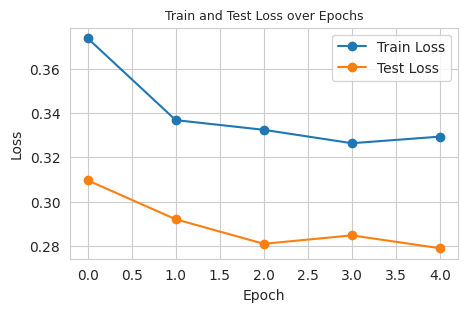

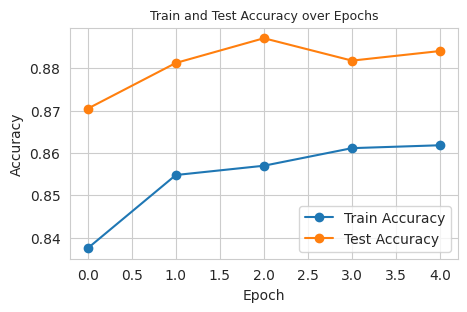

In [35]:
plot_loss(model_zero_df)

#### Data-Augmentation

In [36]:
from torchvision.transforms.functional import InterpolationMode

# Define parameters
img_size = 112
resize_size = 256
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BICUBIC

# Define the transformation pipeline
transform_one = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    transforms.Resize(size = (img_size, img_size), antialias = True,interpolation=interpolation),
    transforms.CenterCrop(size = (img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [37]:
train_dataloader, test_dataloader = get_dataloaders(transforms = transform_one)

Train data:
Dataset ImageFolder
    Number of datapoints: 11879
    Root location: /kaggle/input/melanoma-cancer-dataset/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.3)
               RandomVerticalFlip(p=0.3)
               Resize(size=(112, 112), interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(112, 112))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /kaggle/input/melanoma-cancer-dataset/test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.3)
               RandomVerticalFlip(p=0.3)
               Resize(size=(112, 112), interpo

In [38]:
torch.manual_seed(42) 
NUM_EPOCHS = 5
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_one_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        scheduler = exp_lr_scheduler,
                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4090 | train_acc: 0.8240 | test_loss: 0.3520 | test_acc: 0.8527


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 | train_loss: 0.3870 | train_acc: 0.8302 | test_loss: 0.3357 | test_acc: 0.8536
Epoch: 3 | train_loss: 0.3738 | train_acc: 0.8380 | test_loss: 0.3268 | test_acc: 0.8624
Epoch: 4 | train_loss: 0.3679 | train_acc: 0.8397 | test_loss: 0.3440 | test_acc: 0.8522
Epoch: 5 | train_loss: 0.3693 | train_acc: 0.8359 | test_loss: 0.3324 | test_acc: 0.8549


In [39]:
model_one_df = pd.DataFrame(model_one_results)
model_one_df

,train_loss,train_acc,test_loss,test_acc
0,0.409000,0.823997,0.351977,0.852655
1,0.386964,0.830213,0.335662,0.853579
2,0.373809,0.838038,0.326779,0.862399
3,0.367853,0.839706,0.343977,0.852235
4,0.369275,0.835889,0.332395,0.854911


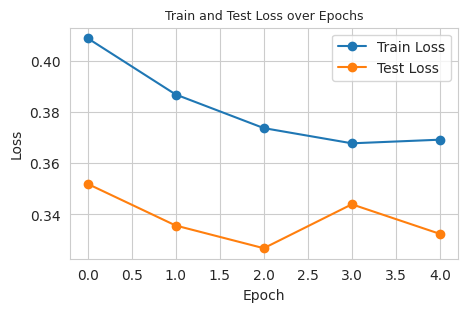

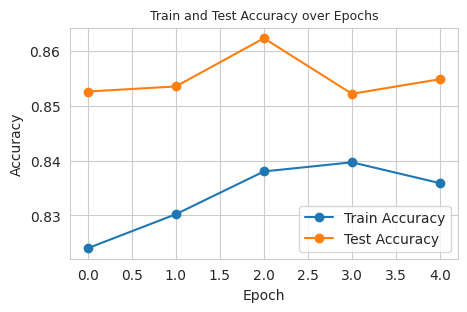

In [40]:
plot_loss(model_one_df)

### EfficientNetB2

In [41]:
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    for param in model.features.parameters():
        param.requires_grad = False
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=class_names)
    ).to(device)
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [42]:
effnetb2 = create_effnetb2() 

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 107MB/s]


[INFO] Created new effnetb2 model.


In [43]:
# get the transformations used on the model
auto_transforms = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [44]:
train_dataloader, test_dataloader = get_dataloaders(transforms = auto_transforms)

Train data:
Dataset ImageFolder
    Number of datapoints: 11879
    Root location: /kaggle/input/melanoma-cancer-dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[288]
               resize_size=[288]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /kaggle/input/melanoma-cancer-dataset/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[288]
               resize_size=[288]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )


In [45]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [46]:
torch.manual_seed(42) 
NUM_EPOCHS = 9
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)
model_two_results = train(model=effnetb2, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        scheduler = scheduler,
                        device = device)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3849 | train_acc: 0.8332 | test_loss: 0.3107 | test_acc: 0.8698
Epoch: 2 | train_loss: 0.3460 | train_acc: 0.8528 | test_loss: 0.2928 | test_acc: 0.8792
Epoch: 3 | train_loss: 0.3319 | train_acc: 0.8567 | test_loss: 0.2796 | test_acc: 0.8840
Epoch: 4 | train_loss: 0.3297 | train_acc: 0.8566 | test_loss: 0.2788 | test_acc: 0.8839
Epoch: 5 | train_loss: 0.3346 | train_acc: 0.8589 | test_loss: 0.2811 | test_acc: 0.8819
Epoch: 6 | train_loss: 0.3325 | train_acc: 0.8554 | test_loss: 0.2748 | test_acc: 0.8851
Epoch: 7 | train_loss: 0.3337 | train_acc: 0.8590 | test_loss: 0.2771 | test_acc: 0.8840
Epoch: 8 | train_loss: 0.3326 | train_acc: 0.8590 | test_loss: 0.2687 | test_acc: 0.8899
Epoch: 9 | train_loss: 0.3347 | train_acc: 0.8561 | test_loss: 0.2691 | test_acc: 0.8906


In [47]:
model_two_df = pd.DataFrame(model_two_results)
model_two_df

,train_loss,train_acc,test_loss,test_acc
0,0.384895,0.833201,0.310747,0.869792
1,0.346032,0.852763,0.292825,0.879152
2,0.331883,0.856723,0.279552,0.883989
3,0.329704,0.856639,0.278835,0.883905
4,0.334598,0.858907,0.281070,0.881888
5,0.332451,0.855415,0.274801,0.885069
6,0.333692,0.859039,0.277063,0.884025
7,0.332565,0.858991,0.268654,0.889857
8,0.334749,0.856051,0.269072,0.890613


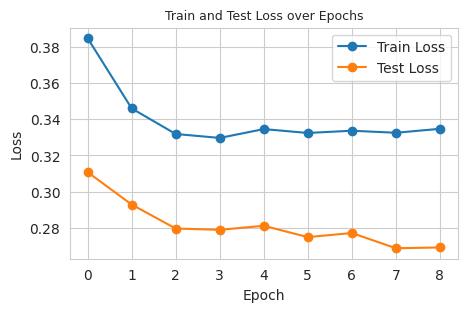

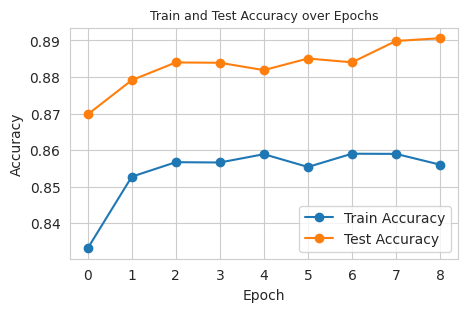

In [48]:
plot_loss(model_two_df)

##### With data-augmentation

In [49]:
train_dataloader, test_dataloader = get_dataloaders(transforms = transform_one)

Train data:
Dataset ImageFolder
    Number of datapoints: 11879
    Root location: /kaggle/input/melanoma-cancer-dataset/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.3)
               RandomVerticalFlip(p=0.3)
               Resize(size=(112, 112), interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(112, 112))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /kaggle/input/melanoma-cancer-dataset/test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.3)
               RandomVerticalFlip(p=0.3)
               Resize(size=(112, 112), interpo

In [50]:
effnetb2 = create_effnetb2() 

[INFO] Created new effnetb2 model.


In [51]:
torch.manual_seed(42) 
NUM_EPOCHS = 9
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)
model_three_results = train(model=effnetb2, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        scheduler = scheduler,
                        device = device)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4236 | train_acc: 0.8156 | test_loss: 0.3608 | test_acc: 0.8440
Epoch: 2 | train_loss: 0.4006 | train_acc: 0.8246 | test_loss: 0.3577 | test_acc: 0.8472
Epoch: 3 | train_loss: 0.3966 | train_acc: 0.8253 | test_loss: 0.3579 | test_acc: 0.8434
Epoch: 4 | train_loss: 0.3896 | train_acc: 0.8266 | test_loss: 0.3522 | test_acc: 0.8446
Epoch: 5 | train_loss: 0.4025 | train_acc: 0.8245 | test_loss: 0.3481 | test_acc: 0.8505
Epoch: 6 | train_loss: 0.3982 | train_acc: 0.8245 | test_loss: 0.3489 | test_acc: 0.8465
Epoch: 7 | train_loss: 0.3927 | train_acc: 0.8291 | test_loss: 0.3532 | test_acc: 0.8448
Epoch: 8 | train_loss: 0.3995 | train_acc: 0.8280 | test_loss: 0.3459 | test_acc: 0.8492
Epoch: 9 | train_loss: 0.3987 | train_acc: 0.8241 | test_loss: 0.3481 | test_acc: 0.8478
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.


In [52]:
model_three_df = pd.DataFrame(model_three_results)
model_three_df

,train_loss,train_acc,test_loss,test_acc
0,0.423584,0.815644,0.360770,0.844002
1,0.400555,0.824573,0.357680,0.847230
2,0.396558,0.825305,0.357944,0.843414
3,0.389642,0.826601,0.352150,0.844590
4,0.402510,0.824501,0.348052,0.850506
5,0.398191,0.824465,0.348852,0.846474
6,0.392740,0.829085,0.353241,0.844794
7,0.399483,0.827993,0.345949,0.849162
8,0.398727,0.824093,0.348091,0.847770


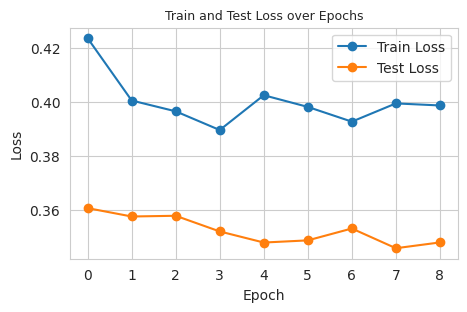

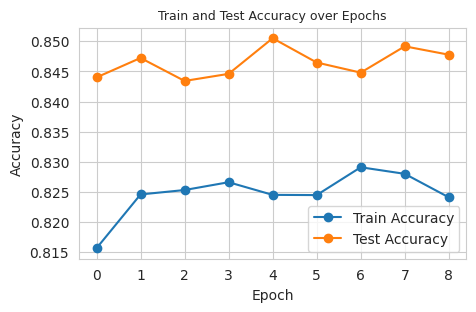

In [53]:
plot_loss(model_three_df)

In [54]:
# # Importing necessary libraries

# import numpy as np

# # PyTorch
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models, datasets, transforms
# from torch.utils.data import DataLoader, random_split
# from torch.cuda.amp import autocast, GradScaler
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Visualization
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Metrics
# from sklearn.metrics import confusion_matrix

# # Suppressing warnings
# from warnings import filterwarnings
# filterwarnings('ignore')

In [55]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Using device : {device}')

In [56]:
# imgSize = 112

# # Training transformer
# transformer = transforms.Compose([
#     transforms.RandomRotation(degrees = 20),
    
#     transforms.RandomHorizontalFlip(p = 0.3),
#     transforms.RandomVerticalFlip(p = 0.3),
    
#     transforms.Resize(size = (imgSize, imgSize), antialias = True),
#     transforms.CenterCrop(size = (imgSize, imgSize)),
    
#     transforms.ToTensor(),
#     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
# ])

# # Validation transformer
# valTransformer = transforms.Compose([
#     transforms.Resize(size = (imgSize, imgSize), antialias = True),
#     transforms.CenterCrop(size = (imgSize, imgSize)),
    
#     transforms.ToTensor(),
#     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
# ])


In [57]:
# path = '/kaggle/input/melanoma-cancer-dataset/train'
# valPath = '/kaggle/input/melanoma-cancer-dataset/test'

# trainData = datasets.ImageFolder(root = path, transform = transformer)
# valData = datasets.ImageFolder(root = valPath, transform = valTransformer)

In [58]:
# # Data loaders
# batchSize = 32

# trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
# valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

In [59]:
# # Using a pre-trained EfficientNetV2L model
# model = models.efficientnet_v2_l(weights = 'DEFAULT')

# # Modifying final classifier layer
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

In [60]:
# model = nn.DataParallel(model).to(device)

In [61]:
# # Defining the loss, optimizer, and annealer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr = 0.001)
# scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

In [62]:
# patience = 5
# minDelta = 0.01
# currentPatience = 0
# bestLoss = float('inf')

In [63]:
# import torch
# torch.cuda.empty_cache()

In [64]:
# # Gradient scaler for mixed-precision training
# scaler = GradScaler()

# # Lists to store training and validation metrics
# trainLosses = []
# valLosses = []
# valAccs = []

# # Training loop
# epochs = 30

# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     runningLoss = 0.0

#     for inputs, labels in trainLoader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         labels = labels.unsqueeze(1).float()

#         optimizer.zero_grad()

#         with autocast():
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         runningLoss += loss.item()

#     trainLoss = runningLoss / len(trainLoader)
#     print(f'Epoch {epoch + 1}/{epochs} - Training Loss : {trainLoss:.2f}')
#     trainLosses.append(trainLoss)

#     # Validation phase
#     model.eval()
#     with torch.no_grad():
#         valLoss = 0.0
#         correct = total = 0

#         for inputs, labels in valLoader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             labels = labels.unsqueeze(1).float()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             valLoss += loss.item()

#             predicted = (torch.sigmoid(outputs) > 0.5).float()
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         avgLoss = valLoss / len(valLoader)
#         accuracy = correct / total * 100

#         print(f'Validation Loss : {avgLoss:.2f} Validation Accuracy : {accuracy:.2f}%\n')
#         valLosses.append(avgLoss)
#         valAccs.append(accuracy)

#         # Early stopping
#         if avgLoss < bestLoss - minDelta:
#             bestLoss = avgLoss
#             currentPatience = 0
#         else:
#             currentPatience += 1
#             if currentPatience >= patience:
#                 print('Early stopping triggered.')
#                 break

#         scheduler.step(avgLoss)